# Testing initial hypotheses about the model dynamics.

The hypotheses are those listed in documentation/model_specification.ipynb

This uses data from simulation batches run using release v0.1 of the model.

Note: there is an open Milestone to complete this analysis during Q2 2021.

In [1]:
DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'

In [2]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import os, sys
MODEL_DIR = os.path.realpath(os.path.dirname('../superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))
from superscript_model import model

In [3]:
rep_count = 10
projects = {}
workers = {}
models = {}

sim_type = 'Basin_w_flex'

for rep in range(rep_count):
    with open(DATA_DIR + sim_type + '/projects_table_rep_%d.pickle' % rep, 'rb') as ifile:
        projects[rep] = pickle.load(ifile) 
        
        # Replicates do not always contain exactly the same projects because of Nulls
        #if rep > 0:
            #assert set(projects[rep].project_id) == set(projects[rep-1].project_id)
            
#             for i in set(projects[rep].project_id):
#                 assert (
#                     int(projects[rep].loc[projects[rep].project_id == i].risk)
#                     == int(projects[rep-1].loc[projects[rep-1].project_id == i].risk)
#                 )
    
    with open(DATA_DIR + sim_type + '/agents_vars_rep_%d.pickle' % rep, 'rb') as ifile:
        workers[rep] = pickle.load(ifile) 
        
    with open(DATA_DIR + sim_type + '/model_vars_rep_%d.pickle' % rep, 'rb') as ifile:
        models[rep] = pickle.load(ifile) 

## Hypotheses:

### a) High risk projects (high stake) attract talent (high OVR)

#### First we look at team OVR versus risk for each project in a single simulation:

In [8]:
min_team_ovr = min(projects[r].team_ovr.min() for r in range(rep_count))
max_team_ovr = max(projects[r].team_ovr.max() for r in range(rep_count))

In [9]:
risk5_ids = projects[0].loc[projects[0].risk==5].project_id
print(len(risk5_ids))
risk10_ids = projects[0].loc[projects[0].risk==10].project_id
print(len(risk10_ids))
risk25_ids = projects[0].loc[projects[0].risk==25].project_id
print(len(risk25_ids))

59
62
70


In [10]:
risk5 = np.zeros((rep_count, len(risk5_ids)))

for r in range(rep_count):
    for i, p in enumerate(risk5_ids):
        
        if p in projects[r].project_id:
            ovr = projects[r].loc[projects[r].project_id == p].team_ovr
            
            if len(ovr)==1:
                ovr = float(ovr)
            else: ovr = np.nan
        risk5[r, i] = ovr

risk10 = np.zeros((rep_count, len(risk10_ids)))

for r in range(rep_count):
    for i, p in enumerate(risk10_ids):
        
        if p in projects[r].project_id:
            ovr = projects[r].loc[projects[r].project_id == p].team_ovr
            
            if len(ovr)==1:
                ovr = float(ovr)
            else: ovr = np.nan
        risk10[r, i] = ovr
        
        
risk25 = np.zeros((rep_count, len(risk25_ids)))

for r in range(rep_count):
    for i, p in enumerate(risk25_ids):
        
        if p in projects[r].project_id:
            ovr = projects[r].loc[projects[r].project_id == p].team_ovr
            
            if len(ovr)==1:
                ovr = float(ovr)
            else: ovr = np.nan
        risk25[r, i] = ovr

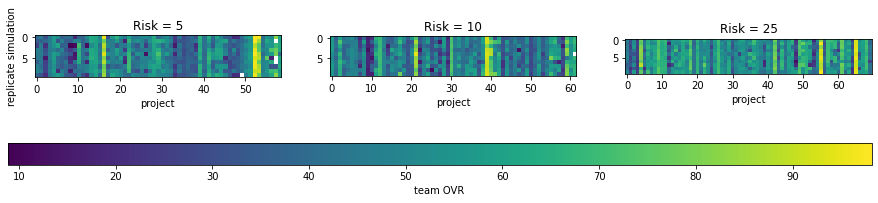

In [11]:
fig = plt.figure(figsize=(15,3))
plt.subplot(1,3,1)

plt.imshow(risk5, vmin=min_team_ovr, vmax=max_team_ovr)
plt.xlabel('project')
plt.ylabel('replicate simulation')
plt.title("Risk = 5")

plt.subplot(1,3,2)

plt.imshow(risk10, vmin=min_team_ovr, vmax=max_team_ovr)
plt.xlabel('project')
#plt.ylabel('replicate simulation')
plt.title("Risk = 10")

plt.subplot(1,3,3)

im3 = plt.imshow(risk25, vmin=min_team_ovr, vmax=max_team_ovr)
plt.xlabel('project')
#plt.ylabel('replicate simulation')
plt.title("Risk = 25")

cbar_ax = fig.add_axes([0.1, 0.0, 0.8, 0.1])
cbar = fig.colorbar(im3, orientation='horizontal', cax=cbar_ax)
cbar.ax.set_xlabel('team OVR');

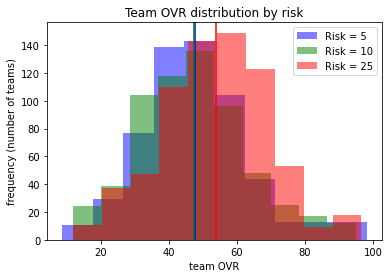

In [12]:
alpha = 0.5
c1 = 'b'
c2 = 'g'
c3 = 'r'

plt.hist(risk5.flat, alpha=alpha, color=c1, label='Risk = 5')
plt.axvline(np.nanmean(risk5.flat), color=c1)
plt.hist(risk10.flat, alpha=alpha, color=c2, label='Risk = 10')
plt.axvline(np.nanmean(risk10.flat), color=c2)
plt.hist(risk25.flat, alpha=alpha, color=c3, label='Risk = 25')
plt.axvline(np.nanmean(risk25.flat), color=c3)
plt.xlabel('team OVR')
plt.ylabel('frequency (number of teams)')
plt.title('Team OVR distribution by risk')
plt.legend();

#### So higher risk projects, do have slightly higher OVR teams on avergae.

#### Next we look at individual worker OVR for each of the workers on each project:

In [13]:
worker_frame = workers[0].iloc[workers[0].index.get_level_values('AgentID') == 0]
contributes = worker_frame.iloc[0].contributes

flatten = lambda t: [item for sublist in t for item in sublist]

def get_all_projects(contributes):
    return set(flatten([contributes[skill] for skill in ['A', 'B', 'C', 'D', 'E']]))

In [14]:
workers_projects = {}

for ri, row in workers[0].iterrows():
    
    if row.contributes is None:
        p = set()
    else:
        p = get_all_projects(row.contributes)
    
    wid = ri[1]

    if wid not in workers_projects.keys():
        workers_projects[wid] = p
    else:
        workers_projects[wid] = workers_projects[wid].union(p)

In [15]:
project_count = [len(val) for val in workers_projects.values()]

#### More than half of workers never work on a project:

In [22]:
print('%.3f' % (len([c for c  in project_count if c==0]) / len(project_count)))

0.523


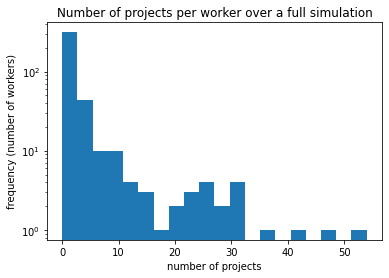

In [30]:
plt.hist(project_count, bins=20)
plt.yscale('log')
plt.xlabel('number of projects')
plt.ylabel('frequency (number of workers)')
plt.title('Number of projects per worker over a full simulation');

In [24]:
ovr = []
risk = []

for w, p_set in workers_projects.items():
    
    for p in p_set:
        
        if p in projects[0].project_id:
            row = projects[0].loc[projects[0].project_id == p]

            start = int(row.start_time)
            if start != 0:
                o = float(workers[0].loc[start, w].ovr)
                if o is not None:
                    ovr.append(o)
                    risk.append(int(row.risk))

In [25]:
print(len(ovr))
print(len(risk))

1074
1074


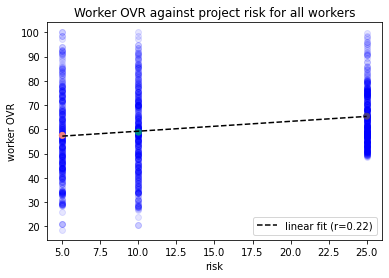

In [27]:
x = np.asarray(risk)
y = np.asarray(ovr)

c1 = 'lightcoral'
c2 = 'darkcyan'
c3 = 'darkslateblue'

mean5 = np.mean([ovr[i]for i,r in enumerate(risk) if r==5])
mean10 = np.mean([ovr[i]for i,r in enumerate(risk) if r==10])
mean25 = np.mean([ovr[i]for i,r in enumerate(risk) if r==25])

plt.scatter(risk, ovr, color=[0,0,1,0.1])
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, x*slope + intercept, color='k', linestyle='--', label='linear fit (r=%.2f)' % r_value)
plt.scatter([5,10,25], [mean5, mean10, mean25], c=[c1,c2,c3])
plt.xlabel('risk')
plt.ylabel('worker OVR')
plt.title('Worker OVR against project risk for all workers')
plt.legend();

#### So higher risk projects do attract higher OVR workers, on average.

In [28]:
risk5 = [val for key, val in zip(risk, ovr) if key==5]
risk10 = [val for key, val in zip(risk, ovr) if key==10]
risk25 = [val for key, val in zip(risk, ovr) if key==25]

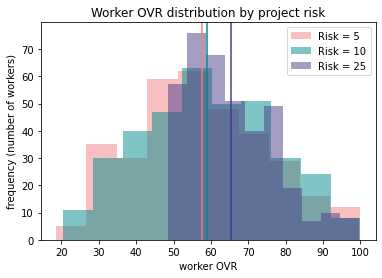

In [29]:
alpha = 0.5

c1 = 'lightcoral'
c2 = 'darkcyan'
c3 = 'darkslateblue'

plt.hist(risk5, alpha=alpha, color=c1, label='Risk = 5')
plt.axvline(np.nanmean(risk5), color=c1)
plt.hist(risk10, alpha=alpha, color=c2, label='Risk = 10')
plt.axvline(np.nanmean(risk10), color=c2)
plt.hist(risk25, alpha=alpha, color=c3, label='Risk = 25')
plt.axvline(np.nanmean(risk25), color=c3)
plt.xlabel('worker OVR')
plt.ylabel('frequency (number of workers)')
plt.title('Worker OVR distribution by project risk')
plt.legend();

### b) Cognitively diverse teams have higher success rate than randomly selected teams

Note: these results are averaged over rep_count replicate simulations.

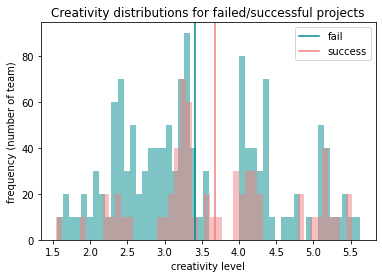

In [303]:
alpha=0.9
av = np.mean

rep_count = 10
creativity_fail = []
creativity_success = []

for rep in range(rep_count):
    creativity_fail.extend(list(projects[0].loc[projects[0].success==False].team_creativity_level))
    creativity_success.extend(list(projects[0].loc[projects[0].success==True].team_creativity_level))
    
plt.hist(creativity_fail, color=c2, alpha=alph, bins=50)
plt.axvline(av(creativity_fail), color=c2, label='fail')
    
plt.hist(creativity_success, color=c1, alpha=alph, bins=50)
plt.axvline(av(creativity_success), color=c1, label='success')


plt.xlabel('creativity level')
plt.ylabel('frequency (number of team)')
plt.title('Creativity distributions for failed/successful projects')
plt.legend();

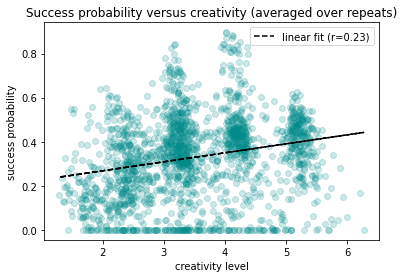

In [317]:
creativity = []
prob = []

for rep in range(rep_count):
    creativity.extend(list(projects[rep].team_creativity_level))
    prob.extend(list(projects[rep].prob))

x = np.asarray(creativity) 
y = np.asarray(prob)

plt.scatter(x, y, color=c2, alpha=0.2)


slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, x*slope + intercept, color='k', linestyle='--', label='linear fit (r=%.2f)' % r_value)

#plt.xscale('log')
plt.xlabel('creativity level')
plt.ylabel('success probability')
plt.title('Success probability versus creativity (averaged over repeats)')
plt.legend();

#### So more creative teams do have a higher probability of success.

### c) Superstars emerge, i.e., workers who get over-proportionally selected to work in high stake projects, and, on the other hand, workers with low OVR are stuck with departmental workload and, over time, get replaced by new workers

#### i) See the above plot of worker OVR against risk -> higher OVR workers tend to work on higher risk projects.

(This could be explored in more depth e.g. look at distribution of Risk across OVR deciles.)

#### ii) Looking at worker activity across OVR ranges:

(Note: here we average across multiple replicate simulations.)

In [46]:
DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'
#DATA_DIR = '../simulation_io/deptwl_0.3_r10_010421_v0.1/'

rep_count = 10
workers = {}

sim_type = 'Basin_w_flex'

for rep in range(rep_count):
 
    with open(DATA_DIR + sim_type + '/agents_vars_rep_%d.pickle' % rep, 'rb') as ifile:
        workers[rep] = pickle.load(ifile) 
        

In [47]:
def on_project(contributes):
    if contributes is None:
        return False
    elif sum([len(item[1]) for item in contributes.items()]) == 0:
        return False
    else:
        return True
    
def ovr_range(ovr):

    if ovr <= 30:
        return 25
    elif 30 < ovr <= 40:
        return 35
    elif 40 < ovr <= 50:
        return 45
    elif 50 < ovr <= 60:
        return 65
    elif 60 < ovr <= 70:
        return 75
    elif ovr > 80:
        return 85

In [48]:
wf = workers[0][['contributes', 'training_remaining', 'ovr']].copy()

for rep in range(1, rep_count):
    wf = wf.append(workers[rep][['contributes', 'training_remaining', 'ovr']])

wf['on_training'] = wf.apply(lambda row: row.training_remaining > 0, axis=1)
wf['on_project'] = wf.apply(lambda row: on_project(row.contributes), axis=1)
wf['ovr_range'] = wf.apply(lambda row: ovr_range(row.ovr), axis=1)

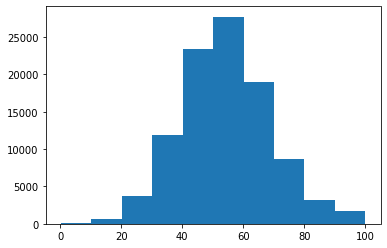

In [49]:
plt.hist(wf.ovr);

In [50]:
wf_agg = wf.groupby(by=['ovr_range']).agg({'on_project': 'sum', 'on_training': 'sum', 'ovr': 'count'}).rename(columns={'ovr':'count'})
wf_agg['slack'] = (wf_agg['count'] - (wf_agg['on_project'] + wf_agg['on_training'])) / wf_agg['count']
wf_agg.on_project = wf_agg['on_project'] / wf_agg['count']
wf_agg.on_training = wf_agg['on_training'] / wf_agg['count']

#### For Departmental workload = 0.1:

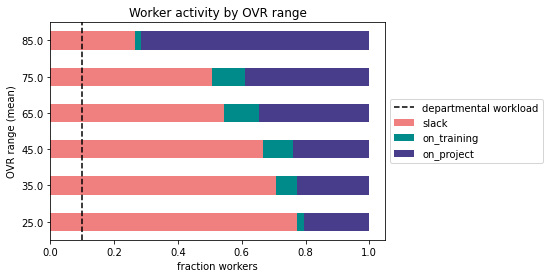

In [51]:
plt.axvline(0.1, color='k', linestyle='--', label='departmental workload')
ax = plt.gca()
(wf_agg[['slack', 'on_training', 'on_project']]
 .plot.barh(stacked=True, color=[c1,c2,c3], ax=ax)
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
plt.ylabel('OVR range (mean)')
plt.xlabel('fraction workers')
plt.title('Worker activity by OVR range');

#### For Departmental workload = 0.3:

(Note: rerun above cells with different DATA_DIR to produce this figure).

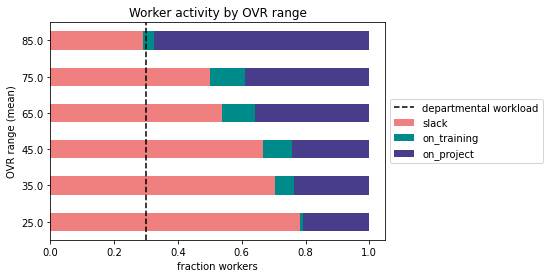

In [45]:
plt.axvline(0.3, color='k', linestyle='--', label='departmental workload')
ax = plt.gca()
(wf_agg[['slack', 'on_training', 'on_project']]
 .plot.barh(stacked=True, color=[c1,c2,c3], ax=ax)
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
plt.ylabel('OVR range (mean)')
plt.xlabel('fraction workers')
plt.title('Worker activity by OVR range');

#### So there is less slack and less training for high OVR workers, and more project work. Note that the lowest OVR workers have little training activity, this is because their OVR is increased as soon as they enter training.

### d) Timeline flexibility pays off (start date can be later) in terms of higher project success rates

In [52]:
DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'
#DATA_DIR = '../simulation_io/deptwl_0.3_r10_010421_v0.1/'

rep_count = 10
m_flex = {}
m_no_flex = {}

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        m_flex[ri] = pickle.load(ifile)

    with open(DATA_DIR + 'Basin/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        m_no_flex[ri] = pickle.load(ifile)

In [53]:
flex = np.zeros((100, rep_count))
no_flex = np.zeros((100, rep_count))

for ri in range(rep_count):
    flex[:,ri] = m_flex[ri].AverageSuccessProbability
    no_flex[:,ri] = m_no_flex[ri].AverageSuccessProbability

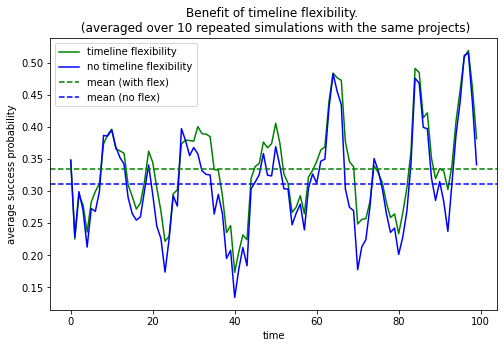

In [54]:
plt.figure(figsize=(8,5))
plt.plot(np.mean(flex, axis=1), 'g', label='timeline flexibility')
plt.plot(np.mean(no_flex, axis=1), 'b', label='no timeline flexibility')
plt.axhline(np.mean(np.mean(flex, axis=1)), color='g', linestyle='--', label='mean (with flex)')
plt.axhline(np.mean(np.mean(no_flex, axis=1)), color='b', linestyle='--', label='mean (no flex)')

plt.ylabel('average success probability')
plt.xlabel('time')
plt.title('Benefit of timeline flexibility. \n (averaged over 10 repeated simulations with the same projects)')
plt.legend();

In [55]:
DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'
#DATA_DIR = '../simulation_io/deptwl_0.3_r10_010421_v0.1/'

rep_count = 10
m_flex = {}
m_no_flex = {}

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/projects_table_rep_%d.pickle' % ri, 'rb') as ifile:
        m_flex[ri] = pickle.load(ifile)

    with open(DATA_DIR + 'Basin/projects_table_rep_%d.pickle' % ri, 'rb') as ifile:
        m_no_flex[ri] = pickle.load(ifile)

In [56]:
cols = ['project_id', 'risk', 'budget', 'prob'] 
mf = m_flex[0][cols]

for rep in range(rep_count):
    mf = pd.merge(mf, m_flex[rep][cols], on=['project_id', 'risk', 'budget'], suffixes=[None, '_%d' % rep])
    
mnf = m_no_flex[0][cols]

for rep in range(rep_count):
    mnf = pd.merge(mnf, m_no_flex[rep][cols], on=['project_id', 'risk', 'budget'], suffixes=[None, '_%d' % rep])    

mf = mf.sort_values('budget')    
mnf = mnf.sort_values('budget')

In [57]:
all_projects = pd.merge(mf, mnf, on=['project_id', 'risk', 'budget'], suffixes=[None, '_nf'])
all_projects = all_projects.transpose()

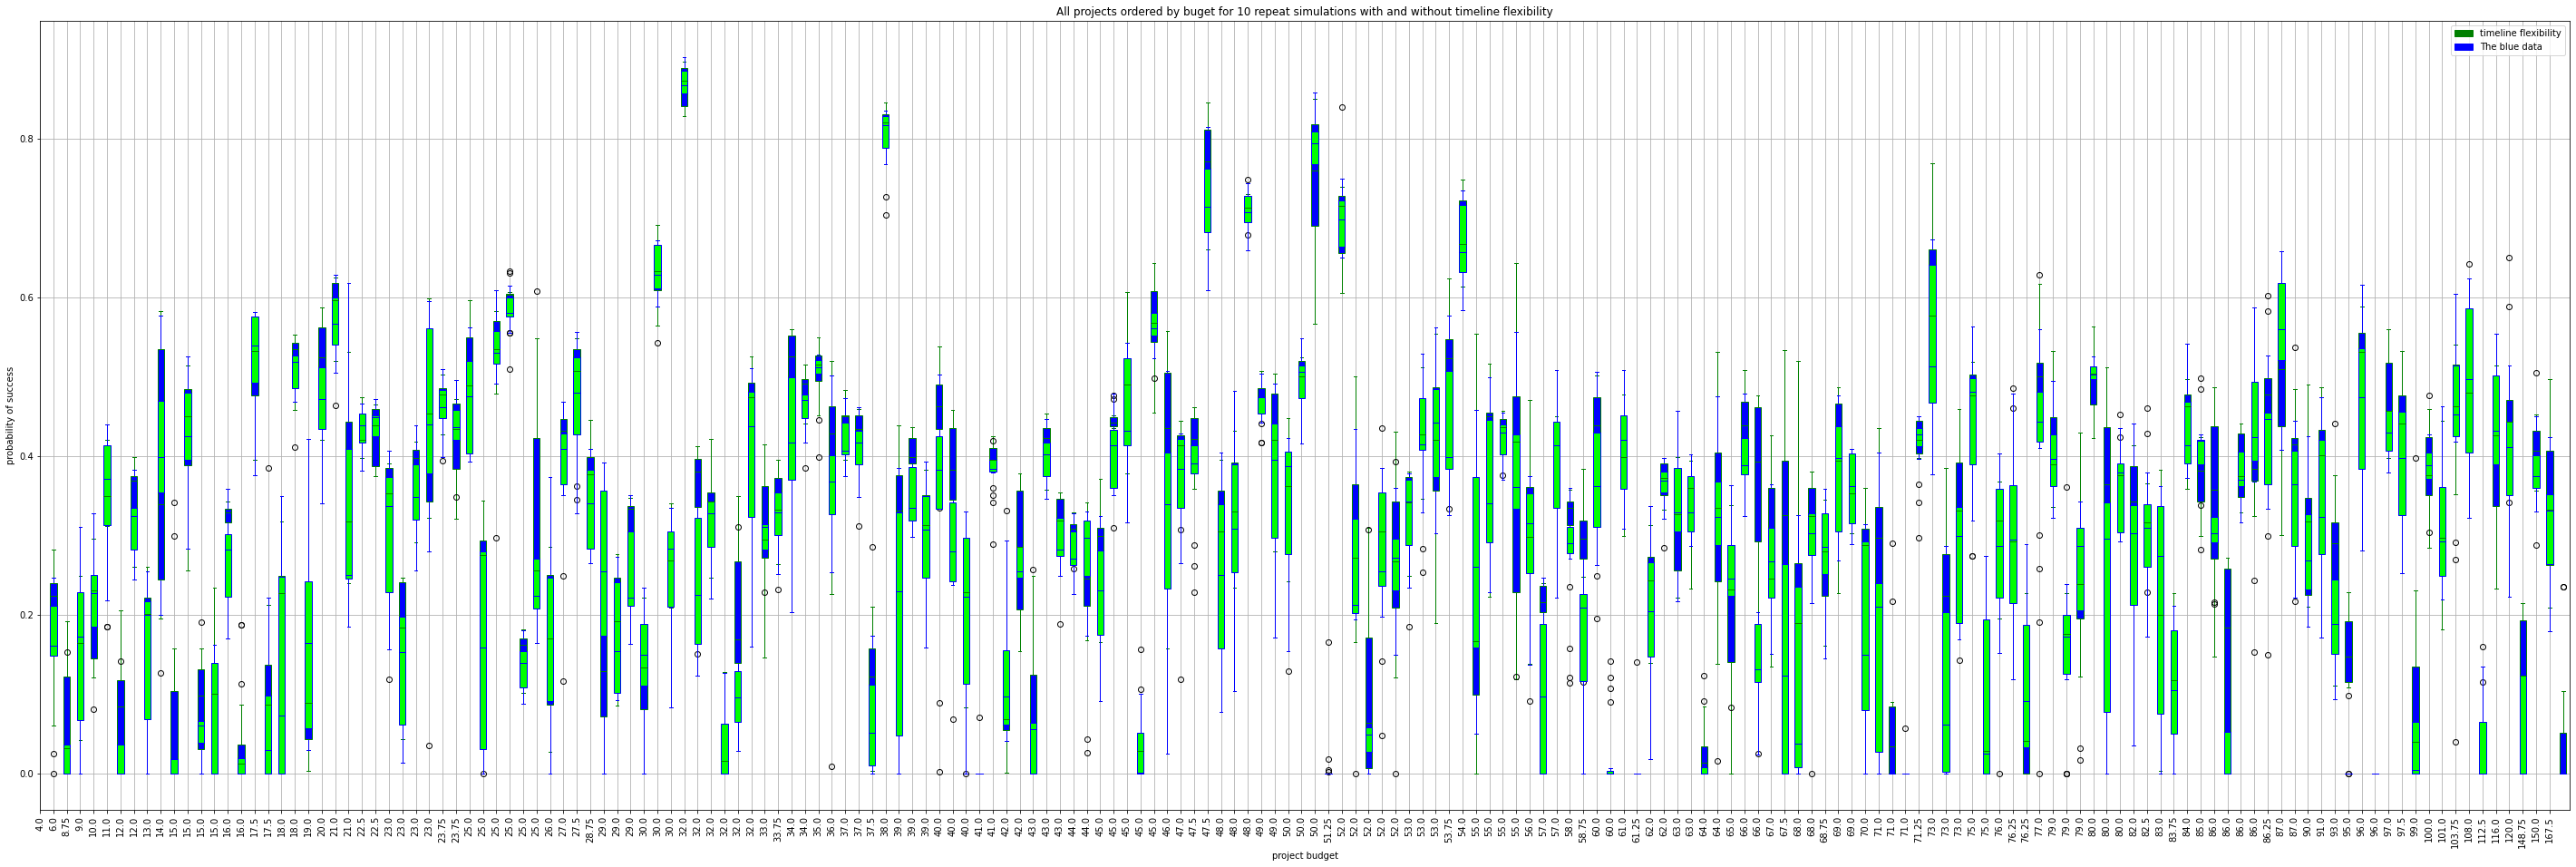

In [59]:
plt.figure(figsize=(50,16))
ax = plt.gca()

colors = [[0,0,1,0.5],
           [0,1,0,0.5]]

bp1 = all_projects.iloc[3:14].boxplot(column=list(all_projects.columns), ax=ax, color='g', patch_artist=True, return_type='dict')
bp2 = all_projects.iloc[14:].boxplot(column=list(all_projects.columns), ax=ax, color='b', patch_artist=True, return_type='dict')
plt.xticks(ticks=range(len(all_projects.columns)), labels=all_projects.loc['budget'], rotation=90)

for ci, bplot in enumerate((bp1, bp2)):
    for patch in bplot['boxes']:
        patch.set_facecolor(colors[ci])
        patch.set_alpha=0.5

green_patch = mpatches.Patch(color='green', label='timeline flexibility')
blue_patch = mpatches.Patch(color='blue', label='no timeline flexibility')
blue_patch = mpatches.Patch(color='blue', label='The blue data')
plt.legend(handles=[green_patch, blue_patch])

plt.xlabel('project budget')
plt.ylabel('probability of success')
plt.title('All projects ordered by buget for 10 repeat simulations with and without timeline flexibility')
plt.savefig('projects_timeline_flex.svg')

#### So timelines flexibility does lead to higher success probabilities on avergae, although the effect is small. 

#### Interestingly, the effect is less pronounced when departmentalworkload is 0.3 (try rerunning the above cells with different DATA_DIR).

### e) Budgetary flexibility pays off (higher budget) in terms of higher project success rates


In [60]:
DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'


rep_count = 9
b_flex = {}
b_no_flex = {}

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/projects_table_rep_%d.pickle' % ri, 'rb') as ifile:
        b_flex[ri] = pickle.load(ifile)

DATA_DIR = '../simulation_io/budget_noflex_r20_030421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/projects_table_rep_%d.pickle' % ri, 'rb') as ifile:
        b_no_flex[ri] = pickle.load(ifile)

In [61]:
value_f = []
risk_f = []
value_nf = []
risk_nf = []

prob_f = []
prob_nf = []

for rep in range(rep_count):
    risk_f.extend(list(b_flex[0].risk))
    value_f.extend(list(b_flex[0].risk * b_flex[0].prob))
    prob_f.extend(list(b_flex[0].prob))
    
    risk_nf.extend(list(b_no_flex[0].risk))
    value_nf.extend(list(b_no_flex[0].risk * b_no_flex[0].prob))
    prob_nf.extend(list(b_no_flex[0].prob))

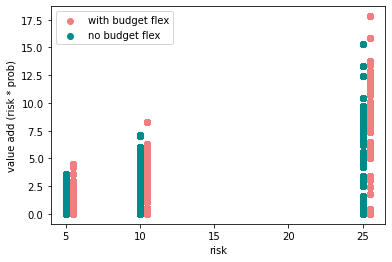

In [62]:
plt.scatter([r+0.5 for r in risk_f], value_f, color=c1, label='with budget flex')
plt.scatter(risk_nf, value_nf, color=c2, label='no budget flex')
plt.xlabel('risk')
plt.ylabel('value add (risk * prob)')
plt.legend();

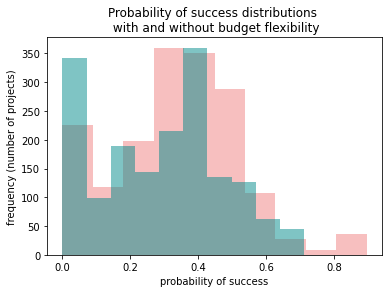

In [63]:
plt.hist(prob_f, color=c1, label='with budget flex', alpha=0.5)
plt.hist(prob_nf, color=c2, label='no budget flex', alpha=0.5)
plt.xlabel('probability of success')
plt.ylabel('frequency (number of projects)')
plt.title('Probability of success distributions \n with and without budget flexibility');

#### So allowing some budget flexibility does lead to higher success probabilities. 

### f) Targeted training pays off in terms of higher project success rate and lower turnover

In [448]:
DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'

rep_count = 10
train = {}
no_train = {}

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        train[ri] = pickle.load(ifile)

DATA_DIR = '../simulation_io/trainload_0.3_r10_010421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        no_train[ri] = pickle.load(ifile)

In [484]:
cols = ['AverageSuccessProbability', 'WorkerTurnover', 'AverageWorkerOvr']
nt = no_train[0][cols]
tt = train[0][cols]

for rep in range(1, rep_count):
    nt = pd.merge(nt, no_train[rep][cols], left_index=True, right_index=True, suffixes=[None, '_%d' % rep])

    tt = pd.merge(tt, train[rep][cols], left_index=True, right_index=True, suffixes=[None, '_%d' % rep])
    
nt = nt.rename(columns={'AverageSuccessProbability': 'AverageSuccessProbability_0'})
tt = tt.rename(columns={'AverageSuccessProbability': 'AverageSuccessProbability_0'})

nt = nt.rename(columns={'AverageWorkerOvr': 'AverageWorkerOvr_0'})
tt = tt.rename(columns={'AverageWorkerOvr': 'AverageWorkerOvr_0'})

nt = nt.rename(columns={'WorkerTurnover': 'WorkerTurnover_0'})
tt = tt.rename(columns={'WorkerTurnover': 'WorkerTurnover_0'})

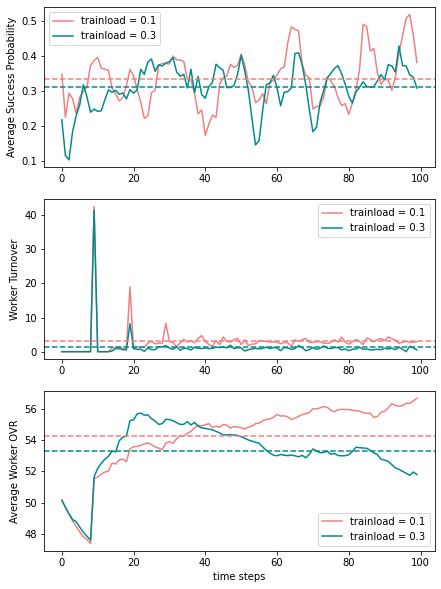

In [492]:
plt.figure(figsize=(7,10))
plt.subplot(3,1,1)
train_succees = tt[['AverageSuccessProbability_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(train_succees, color=c1, label='trainload = 0.1')

no_train_succees = nt[['AverageSuccessProbability_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(no_train_succees, color=c2, label='trainload = 0.3')

plt.axhline(np.mean(train_succees), c=c1, linestyle='--')
plt.axhline(np.mean(no_train_succees), c=c2, linestyle='--')
plt.ylabel('Average Success Probability')
plt.legend();

plt.subplot(3,1,2)
train_succees = tt[['WorkerTurnover_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(train_succees, color=c1, label='trainload = 0.1')

no_train_succees = nt[['WorkerTurnover_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(no_train_succees, color=c2, label='trainload = 0.3')

plt.axhline(np.mean(train_succees), c=c1, linestyle='--')
plt.axhline(np.mean(no_train_succees), c=c2, linestyle='--')
#plt.xlabel('time steps')
plt.ylabel('Worker Turnover')
plt.legend();

plt.subplot(3,1,3)
train_succees = tt[['AverageWorkerOvr_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(train_succees, color=c1, label='trainload = 0.1')

no_train_succees = nt[['AverageWorkerOvr_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(no_train_succees, color=c2, label='trainload = 0.3')

plt.axhline(np.mean(train_succees), c=c1, linestyle='--')
plt.axhline(np.mean(no_train_succees), c=c2, linestyle='--')
plt.xlabel('time steps')
plt.ylabel('Average Worker OVR')
plt.legend();

#### The effects here are subtle:

* more training does lead to reduced turnover, but this might just be because fewer workers are inactive (because they are on training courses).
* initially the benefits of more training are offset by the fact that fewer workers are available to choose from for project work.
* the increased training only benefits worker OVR initially after which it declines.

#### It might be necessary to alter the training mechanism. Or to study the impact of more effective training. (See end of this notebook.)

### g) Some slack in the system, i.e., a utilization rate of workers <100% will add value

Here we compare normal simulation against, higher levels of departmental workload (0.3, 0.6). 

Note: the other suggestion was to vary the number of projects per timestep, which will be added to the analysis in the next milestone.

In [64]:
rep_count = 10
norm = {}
dept3 = {}
#dept6 = {}


DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        norm[ri] = pickle.load(ifile)

DATA_DIR = '../simulation_io/deptwl_0.3_r10_010421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        dept3[ri] = pickle.load(ifile)
        
# DATA_DIR = '../simulation_io/deptwl_0.6_r20_030421_v0.1/'

# for ri in range(rep_count):
    
#     with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
#         dept6[ri] = pickle.load(ifile)

In [65]:
cols = ['AverageSuccessProbability', 'Slack', 'AverageWorkerOvr', 'WorkerTurnover']
nd = norm[0][cols]
d3 = dept3[0][cols]

for rep in range(1, rep_count):
    nd = pd.merge(nd, norm[rep][cols], left_index=True, right_index=True, suffixes=[None, '_%d' % rep])

    d3 = pd.merge(d3, dept3[rep][cols], left_index=True, right_index=True, suffixes=[None, '_%d' % rep])
    
nd = nd.rename(columns={'AverageSuccessProbability': 'AverageSuccessProbability_0'})
d3 = d3.rename(columns={'AverageSuccessProbability': 'AverageSuccessProbability_0'})

nd = nd.rename(columns={'AverageWorkerOvr': 'AverageWorkerOvr_0'})
d3 = d3.rename(columns={'AverageWorkerOvr': 'AverageWorkerOvr_0'})

nd = nd.rename(columns={'Slack': 'Slack_0'})
d3 = d3.rename(columns={'Slack': 'Slack_0'})

nd = nd.rename(columns={'WorkerTurnover': 'WorkerTurnover_0'})
d3 = d3.rename(columns={'WorkerTurnover': 'WorkerTurnover_0'})

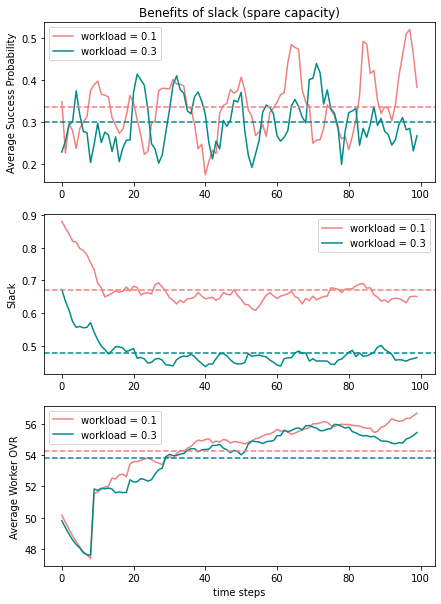

In [66]:
plt.figure(figsize=(7,10))
plt.subplot(3,1,1)
train_succees = nd[['AverageSuccessProbability_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(train_succees, color=c1, label='workload = 0.1')

no_train_succees = d3[['AverageSuccessProbability_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(no_train_succees, color=c2, label='workload = 0.3')

plt.axhline(np.mean(train_succees), c=c1, linestyle='--')
plt.axhline(np.mean(no_train_succees), c=c2, linestyle='--')
plt.ylabel('Average Success Probability')
plt.title('Benefits of slack (spare capacity)')
plt.legend();

plt.subplot(3,1,2)
train_succees = nd[['Slack_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(train_succees, color=c1, label='workload = 0.1')

no_train_succees = d3[['Slack_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(no_train_succees, color=c2, label='workload = 0.3')

plt.axhline(np.mean(train_succees), c=c1, linestyle='--')
plt.axhline(np.mean(no_train_succees), c=c2, linestyle='--')
#plt.xlabel('time steps')
plt.ylabel('Slack')
plt.legend();

plt.subplot(3,1,3)
train_succees = nd[['AverageWorkerOvr_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(train_succees, color=c1, label='workload = 0.1')

no_train_succees = d3[['AverageWorkerOvr_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(no_train_succees, color=c2, label='workload = 0.3')

plt.axhline(np.mean(train_succees), c=c1, linestyle='--')
plt.axhline(np.mean(no_train_succees), c=c2, linestyle='--')
plt.xlabel('time steps')
plt.ylabel('Average Worker OVR')
plt.legend();

#### This is as expected. Interestingly worker OVR increases marginally faster with more slack, presumably due to project work.

### h) Too much slack in the system will increase turn-over (i.e., too many workers are not engaged in projects or trainings, the median skill level drops and workers get replaced)

Note: this analysis will be expanded in the next milestone.

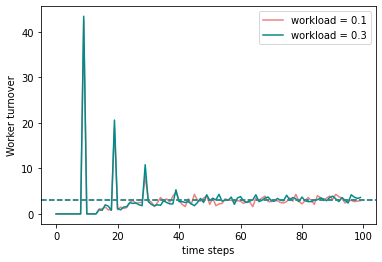

In [67]:
turnover_n = nd[['WorkerTurnover_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(turnover_n, color=c1, label='workload = 0.1')

turnover_d = d3[['WorkerTurnover_%d' % r for r in range(rep_count)]].mean(axis=1)
plt.plot(turnover_d, color=c2, label='workload = 0.3')

plt.axhline(np.mean(turnover_n), c=c1, linestyle='--')
plt.axhline(np.mean(turnover_d), c=c2, linestyle='--')
plt.xlabel('time steps')
plt.ylabel('Worker turnover')

#plt.yscale('log')
plt.legend();

#### Currently we are not seeing this effect - possibly we would with Workload = 0.6?
#### Try running with one project per timestep

### i) Low OVR workers stay low OVR and eventually get replaced, et vice versa (“the rich get richer” effect)

In [68]:
rep_count = 10
workers = {}



DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/agents_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        workers[ri] = pickle.load(ifile)
        workers[ri] = workers[ri].loc[50:,:]
        
        if ri == 0:
            repl = workers[0].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0], 'timesteps_inactive': max})
        else:
            repl = repl.append(workers[ri].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0], 'timesteps_inactive': max}))

In [69]:
sum(workers[0].timesteps_inactive==9)

174

In [70]:
#repl = workers[0].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0], 'timesteps_inactive': max})
repl['quartile'] = pd.qcut(repl.ovr, 4)

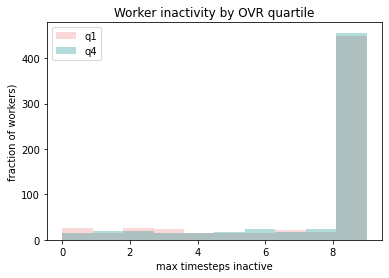

In [71]:
alpha = 0.3

plt.hist(repl.loc[repl.quartile == repl.quartile.unique()[0]].timesteps_inactive, label='q1', alpha=alpha, color=c1)


#plt.hist(repl.loc[repl.quartile == repl.quartile.unique()[1]].timesteps_inactive, label='q2', alpha=alpha)

#plt.hist(repl.loc[repl.quartile == repl.quartile.unique()[2]].timesteps_inactive, label='q3', alpha=alpha)

plt.hist(repl.loc[repl.quartile == repl.quartile.unique()[3]].timesteps_inactive, label='q4', alpha=alpha, color=c2)


plt.xlabel('max timesteps inactive')
plt.ylabel('fraction of workers)')
plt.title('Worker inactivity by OVR quartile')
#plt.yscale('log')
plt.legend();


In [72]:
repl['decile'] = pd.qcut(repl.ovr, 10, labels=range(1,11))

In [73]:
inactivity_by_decile = pd.DataFrame()
inactivity_by_decile['decile'] = range(1,11)

inactivity_by_decile['frac_replaced'] = [
    sum(repl.loc[repl.decile == i].timesteps_inactive==9) / len(repl.loc[repl.decile == i])
    for i in range(1,11)
]
inactivity_by_decile['count'] = [
    len(repl.loc[repl.decile == i])
    for i in range(1,11)
    
]
inactivity_by_decile['mean ovr'] = [
    np.mean(repl.loc[repl.decile == i].ovr)
    for i in range(1,11)
    
]

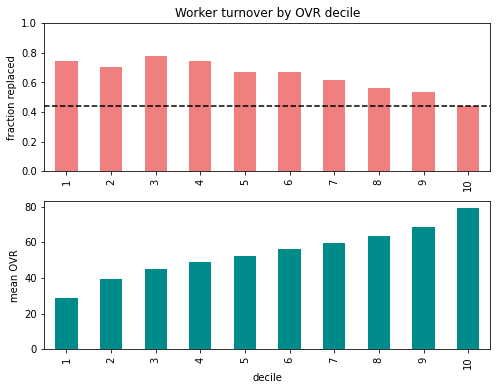

In [74]:
plt.figure(figsize=(8, 6))
ax1 = plt.subplot(2,1,1)
inactivity_by_decile.plot.bar(x='decile', y='frac_replaced', legend=False, ax=ax1, color=c1)
plt.axhline(float(inactivity_by_decile.loc[inactivity_by_decile.decile==10].frac_replaced), linestyle='--', color='k')
plt.ylabel('fraction replaced')
plt.title('Worker turnover by OVR decile')
plt.xlabel('')
plt.ylim([0,1]);

ax2 = plt.subplot(2,1,2)
inactivity_by_decile.plot.bar(x='decile', y='mean ovr', legend=False, ax=ax2, color=c2)
plt.ylabel('mean OVR');

### j) More and earlier training mitigates “the rich get richer” effect 

Run simulations with different training parameters...

In [75]:
rep_count = 10
workers = {}

models = {}

DATA_DIR = '../simulation_io/trainboost_r10_010421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        models[ri] = pickle.load(ifile)
        
    with open(DATA_DIR + 'Basin_w_flex/agents_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        workers[ri] = pickle.load(ifile)
        workers[ri] = workers[ri].loc[50:, :]
        
        if ri == 0:
            repl2 = workers[0].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0], 'timesteps_inactive': max})
        else:
            repl2 = repl2.append(workers[ri].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0], 'timesteps_inactive': max}))

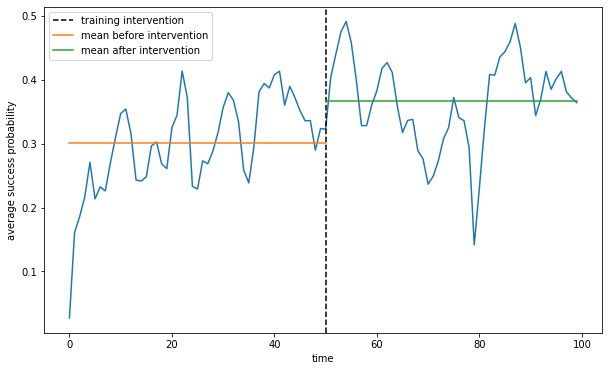

In [76]:
plt.figure(figsize=(10,6))
plt.plot(models[0].AverageSuccessProbability)
plt.axvline(50, color='k', linestyle='--', label='training intervention')
plt.plot(
    [0,50], 
    [np.mean(list(models[0].AverageSuccessProbability)[0:50]),
     np.mean(list(models[0].AverageSuccessProbability)[0:50])
    ],
    label='mean before intervention'
)
plt.plot(
    [50,99], 
    [np.mean(list(models[0].AverageSuccessProbability)[50:]),
     np.mean(list(models[0].AverageSuccessProbability)[50:])
    ],
    label='mean after intervention'
)
plt.ylabel('average success probability')
plt.xlabel('time')
plt.legend();

## TODO: produce above plot for average over replicates

In [77]:
repl2['decile'] = pd.qcut(repl2.ovr, 10, labels=range(1,11))

In [78]:
inactivity_by_decile2 = pd.DataFrame()
inactivity_by_decile2['decile'] = range(1,11)

inactivity_by_decile2['frac_replaced'] = [
    sum(repl2.loc[repl2.decile == i].timesteps_inactive==9) / len(repl2.loc[repl2.decile == i])
    for i in range(1,11)
]
inactivity_by_decile2['count'] = [
    len(repl2.loc[repl2.decile == i])
    for i in range(1,11)
    
]
inactivity_by_decile2['mean ovr'] = [
    np.mean(repl2.loc[repl2.decile == i].ovr)
    for i in range(1,11)
    
]

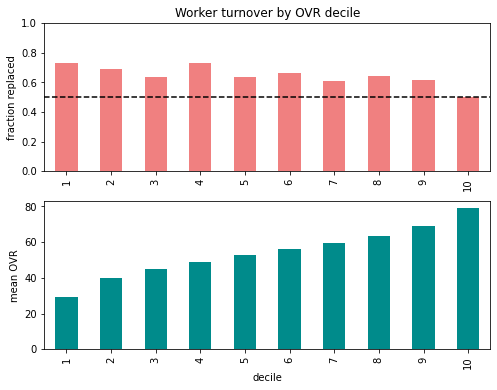

In [79]:
plt.figure(figsize=(8, 6))
ax1 = plt.subplot(2,1,1)
inactivity_by_decile2.plot.bar(x='decile', y='frac_replaced', legend=False, ax=ax1, color=c1)
plt.axhline(float(inactivity_by_decile2.loc[inactivity_by_decile.decile==10].frac_replaced), linestyle='--', color='k')
plt.ylabel('fraction replaced')
plt.title('Worker turnover by OVR decile')
plt.xlabel('')
plt.ylim([0,1]);

ax2 = plt.subplot(2,1,2)
inactivity_by_decile2.plot.bar(x='decile', y='mean ovr', legend=False, ax=ax2, color=c2)
plt.ylabel('mean OVR');

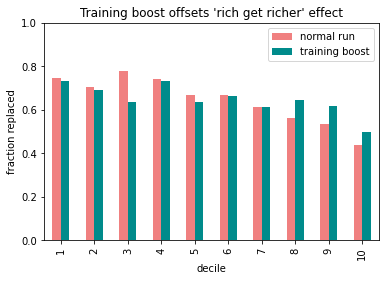

In [81]:
merged = inactivity_by_decile.merge(inactivity_by_decile2, on='decile')
merged = merged.rename(columns={'frac_replaced_x': 'normal run', 'frac_replaced_y': 'training boost'})
merged.plot.bar(x='decile', y=['normal run','training boost'], color=[c1,c2])
plt.ylabel('fraction replaced')
plt.title("Training boost offsets 'rich get richer' effect")
plt.ylim([0,1]);

### k) For high OVR workers, a high portion of their OVR change is due to project work experience while for low OVR workers a high portion of the OVR change is due to training

In [82]:
def ovr(hard_skills):
    
    value = 0
    count = 0
    for skill in hard_skills.keys():
        if hard_skills[skill] > 0.0:
            count += 1
            value += hard_skills[skill]
            
    return 20 * value / count

In [83]:
def ovr_change(hard_skills, delta):
    
    orig = ovr(hard_skills)
    
    new_skills = {skill: hard_skills[skill] + delta[skill] 
                  for skill in hard_skills}

    return ovr(new_skills) - orig

In [91]:
rep_count = 10
workers = {}

models = {}

DATA_DIR = '../simulation_io/normal_run_r10_010421_v0.1/'

for ri in range(rep_count):
    
    with open(DATA_DIR + 'Basin_w_flex/model_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        models[ri] = pickle.load(ifile)
        
    with open(DATA_DIR + 'Basin_w_flex/agents_vars_rep_%d.pickle' % ri, 'rb') as ifile:
        workers[ri] = pickle.load(ifile)
        workers[ri] = workers[ri].loc[50:, :]
        workers[ri]['delta_train'] = [ovr_change(row.hard_skills, row.training) for ri,row in workers[ri].iterrows()]
        workers[ri]['delta_decay'] = [ovr_change(row.hard_skills, row.skill_decay) for ri,row in workers[ri].iterrows()]
        workers[ri]['delta_peer'] = [ovr_change(row.hard_skills, row.peer_assessment) for ri,row in workers[ri].iterrows()]
        
        if ri == 0:
            D = workers[ri].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0],
                                       'delta_train': sum,
                                       'delta_decay': sum,
                                       'delta_peer': sum,
                                       })
            
        else:
            D = D.append(
                workers[ri].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0],
                                       'delta_train': sum,
                                       'delta_decay': sum,
                                       'delta_peer': sum,
                                       })
            )

In [85]:
# workers[0]['delta_train'] = [ovr_change(row.hard_skills, row.training) for ri,row in workers[0].iterrows()]
# workers[0]['delta_decay'] = [ovr_change(row.hard_skills, row.skill_decay) for ri,row in workers[0].iterrows()]
# workers[0]['delta_peer'] = [ovr_change(row.hard_skills, row.peer_assessment) for ri,row in workers[0].iterrows()]

In [86]:
# D = workers[0].groupby(by=['AgentID']).agg({'ovr': lambda x: x.iloc[0],
#                                         'delta_train': sum,
#                                         'delta_decay': sum,
#                                         'delta_peer': sum,
#                                        })

D['delta_total'] = D.delta_train + D.delta_decay + D.delta_peer
D['delta_abs'] = D.delta_train.abs() + D.delta_decay.abs() + D.delta_peer.abs()
D['delta_train_rel'] = D['delta_train'] / D['delta_abs']
D['delta_decay_rel'] = D['delta_decay'] / D['delta_abs']
D['delta_peer_rel'] = D['delta_peer'] / D['delta_abs']

In [87]:
D = D.sort_values('ovr')
D['decile'] = pd.qcut(D.ovr, 10, labels=range(1,11))
D

,ovr,delta_train,delta_decay,delta_peer,delta_total,delta_abs,delta_train_rel,delta_decay_rel,delta_peer_rel,decile
AgentID,,,,,,,,,,
319,1.617068,0.0,-0.139849,0.000000,-0.139849,0.139849,0.0,-1.000000,0.000000,1
327,3.593330,0.0,-0.310761,0.000000,-0.310761,0.310761,0.0,-1.000000,0.000000,1
267,5.817141,0.0,-0.503082,0.000000,-0.503082,0.503082,0.0,-1.000000,0.000000,1
299,5.958662,0.0,-0.515321,0.000000,-0.515321,0.515321,0.0,-1.000000,0.000000,1
230,5.998493,0.0,-0.238752,0.000000,-0.238752,0.238752,0.0,-1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
8,96.528511,0.0,-14.418107,8.354033,-6.064074,22.772140,0.0,-0.633147,0.366853,10
42,97.173852,0.0,-16.353771,14.986358,-1.367414,31.340129,0.0,-0.521816,0.478184,10
210,100.000000,0.0,-16.648129,-8.498901,-25.147031,25.147031,0.0,-0.662032,-0.337968,10


In [88]:
Dagg = D.groupby(by=['decile']).agg({'ovr': np.mean, 
                              'delta_train_rel': np.mean,
                              'delta_decay_rel': np.mean,
                              'delta_peer_rel': np.mean,
                             })

In [89]:
Dagg

,ovr,delta_train_rel,delta_decay_rel,delta_peer_rel
decile,,,,
1,28.778222,0.184334,-0.755364,0.022237
2,39.557049,0.235999,-0.703352,0.038078
3,44.969678,0.217769,-0.713637,0.024634
4,49.028733,0.185756,-0.747923,0.045707
5,52.494857,0.242199,-0.686421,0.032063
6,56.200884,0.174465,-0.711926,0.085224
7,59.712190,0.178163,-0.677302,0.103553
8,63.444307,0.165888,-0.692545,0.109946
9,68.351607,0.183130,-0.641822,0.144330


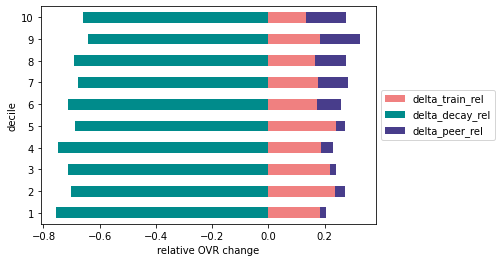

In [90]:
(Dagg[['delta_train_rel', 'delta_decay_rel', 'delta_peer_rel']]
 .plot.barh(stacked=True, color=[c1,c2,c3])
 .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
plt.xlabel('relative OVR change');

#### TODO: check this! e.g. average OVR over time by decile/quartile.

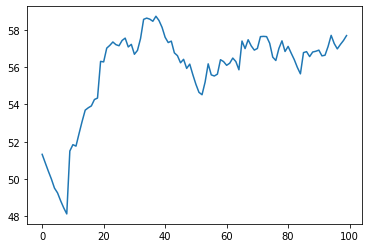

In [100]:
plt.plot(models[4].AverageWorkerOvr)

### Based on these intial results, the following could be candidates for changing mechanism or parameters:

* Training: skill increases as soon as they enter training (not realistic).
* Training: alter mechanism of skill increase? Currently maxes out once all workers approach third quartile. (See plots above with training load = 0.3).